In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl  
import time  
from openpyxl.styles import Alignment 
import win32com.client
from pywintypes import com_error

### Data Formatting 

Changing the original subject names to :

"subject 1", "subject 2", "subject 3", "subject 4", "subject 5"

In [17]:
def format_dataframe(df):
    y = list(df.columns)
    x = list(df.columns)
    j = 1
    for i in range(5,len(x)-1):
        x[i] = "subject "+str(j)
        j += 1
    df.columns = x
    return df, y[5:10]
df = pd.read_excel("Required Format.xlsx")
df, subject_names = format_dataframe(df)
df

,Name,Roll No.,Gender,College Code,College Name,subject 1,subject 2,subject 3,subject 4,subject 5,Attendace
0,Yasho,17055,M,4095,I2IT,8.11,7.68,7.11,7.43,8.18,98
1,Piyush,17056,M,4095,I2IT,6.48,5.90,4.15,4.29,4.96,83
2,Aayush,17057,M,4095,I2IT,8.41,8.24,7.52,8.25,7.75,76
3,Pratik,17058,M,4095,I2IT,7.33,6.83,6.33,6.79,6.89,60


### Performing General Analysis on the data:

1. Finding out the maximum marks scored in each subjet
2. Finding ot the average marksin each subject

In [18]:
def gen_analysis(df):
    s1 = max(df["subject 1"])
    s2 = max(df["subject 2"])
    s3 = max(df["subject 3"])
    s4 = max(df["subject 4"])
    s5 = max(df["subject 5"])
    max_marks = [s1, s2, s3, s4, s5]

    s1 = np.mean(df["subject 1"])
    s2 = np.mean(df["subject 2"])
    s3 = np.mean(df["subject 3"])
    s4 = np.mean(df["subject 4"])
    s5 =  np.mean(df["subject 5"])
    avg_marks = [s1, s2, s3, s4, s5]
    
    s_1 = pd.Series(max_marks, index = ["subject 1", "subject 2", "subject 3", "subject 4", "subject 5"])
    s_2 = pd.Series(avg_marks, index = ["subject 1", "subject 2", "subject 3", "subject 4", "subject 5"])

    analysis = pd.DataFrame([s_1, s_2])
    analysis = analysis.T
    analysis.rename(columns={0:"Max Marks", 1:"Average Marks"}, inplace = True)
    return analysis, avg_marks, max_marks

analysis, avg_marks, max_marks = gen_analysis(df)
analysis

,Max Marks,Average Marks
subject 1,8.41,7.5825
subject 2,8.24,7.1625
subject 3,7.52,6.2775
subject 4,8.25,6.6900
subject 5,8.18,6.9450


### Graph for comparing students performance with the other students

1. Joint Bar Graph with parameters:
    - Highest marks in a subject
    - Average marks in a subject
    - Marks score by student in a subject

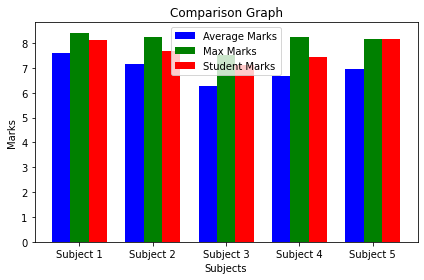

In [19]:
def student_perf_graph(student_marks, avg_marks, max_marks, subject_names):
    n_groups = 5
    data = [avg_marks, max_marks]
    data.append(student_marks)
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.25

    col_1 = plt.bar(index, data[0], bar_width, color='b', label='Average Marks')

    col_2 = plt.bar(index + bar_width, data[1], bar_width, color='g', label='Max Marks')

    col_3 = plt.bar(index + bar_width*2, data[2], bar_width, color='r', label='Student Marks')


    plt.xlabel('Subjects')
    plt.ylabel('Marks')
    plt.title('Comparison Graph')
    plt.xticks(index + bar_width, tuple(subject_names))
    plt.legend()
    plt.savefig("plot_1.png", dpi = 150)
    plt.tight_layout()
    plt.show()

student = list(df.iloc[0])[5:10]
graph = student_perf_graph(student, avg_marks, max_marks, subject_names)
graph

### Generating the student Report Card:

- Report contains the tabular data of students marks
- Row with total marks is added

In [20]:
def report_card(student_marks, subject_names):
    subjects = ["subject 1", "subject 2", "subject 3", "subject 4", "subject 5"]
    min_marks = [4 for i in range(5)]
    max_marks = [10 for i in range(5)]

    student_marks.append(sum(student_marks)/5)
    grades = []
    for i in range(len(student_marks)):
        if student_marks[i] >= 9:
            grades.append("O")
        elif 9 > student_marks[i] >= 8:
            grades.append("A")
        elif 8 > student_marks[i] >= 7:
            grades.append("B")
        elif 7 > student_marks[i] >= 6:
            grades.append("C")
        elif 6 > student_marks[i] >= 5:
            grades.append("D")
        elif 5 > student_marks[i] >= 4:
            grades.append("P")
        else:
            grades.append("F")
        
    
    s1 = pd.Series(min_marks, index = subjects)
    s2 = pd.Series(max_marks, index = subjects)
    s3 = pd.Series(student_marks[:-1], index = subjects)
    
    report = pd.DataFrame((s1, s2, s3), index = ["Min", "Max", "Student"])
    report = report.T
    total = sum(list(report["Student"]))
    report = report.append({"Min" : sum(report["Min"]), "Max" : sum(report["Max"])
                           ,"Student" : total}, ignore_index = True)
    subject_names.append("Total")
    report["Subjects"] = subject_names
    report["Grade"] = grades
    report.set_index("Subjects", inplace = True)
    
    return report

r = report_card(student, subject_names)
r

,Min,Max,Student,Grade
Subjects,,,,
Subject 1,4.0,10.0,8.11,A
Subject 2,4.0,10.0,7.68,B
Subject 3,4.0,10.0,7.11,B
Subject 4,4.0,10.0,7.43,B
Subject 5,4.0,10.0,8.18,A
Total,20.0,50.0,38.51,B


### Formatting the Report:

- Adding credentials like:
    - Name 
    - Roll number
    - Gender
    - College code
    - College name
    - Attendance
- Inserting the comparison graph

In [6]:

def final_format(r, x):
    mks = list(r["Student"])[-1]
    percentage = (mks/50)*100

    wb = openpyxl.load_workbook("sample_file.xlsx")  
    sheet = wb.active  
    
    sheet.merge_cells('A1:B1')
    sheet.merge_cells('A13:C13')
    sheet.merge_cells('C1:E1')
    sheet.merge_cells('C2:E2')
    sheet.merge_cells('C3:E3')
    
    cell = sheet.cell(row = 3, column =3)
    cell.value = "Name:   "+str(x[0])
    cell.alignment = Alignment(horizontal='center', vertical='center')
    
    cell = sheet.cell(row = 1, column =3)
    cell.value = "College Name:   "+str(x[4])
    cell.alignment = Alignment(horizontal='center', vertical='center')
    
    cell = sheet.cell(row = 2, column =3)
    cell.value = "Attendance:        "+str(x[-1])+"%"
    cell.alignment = Alignment(horizontal='center', vertical='center')
    
    cell = sheet.cell(row = 1, column =1)
    cell.value = "College Code:   "+str(x[3])
    cell.alignment = Alignment(horizontal='left', vertical='center')
    
    
    sheet['A2'] = "Gender"  
    cell = sheet.cell(row = 2, column =2)
    cell.value = x[2]
    cell.alignment = Alignment(horizontal='right', vertical='center')
    
    
    sheet['A3'] = "Roll No." 
    sheet['B3'] = x[1]
    
    
    cell = sheet.cell(row = 13, column = 1)
    cell.value = "Percentage   =        "+str(percentage)+"%"
    cell.alignment = Alignment(horizontal='left', vertical='center')

    for j in range(1,6):
        for i in range(6, 12):
            cell = sheet.cell(row = i, column = j)
            cell.alignment = Alignment(horizontal='center', vertical='center')

    img = openpyxl.drawing.image.Image('plot_1.png')
    img.height = 300
    img.width = 450
    sheet.add_image(img, "A15")
    wb.save("sample_file.xlsx")
    


### Finally converting the Excel sheet to PDF 

In [7]:
def convert_to_pdf(i):
    # Path to original excel file
    WB_PATH = r'C:\Users\HP\Desktop\Jupyter Notebooks\sample_file.xlsx'
    # PDF path when saving
    
    PATH_TO_PDF = r'C:\Users\HP\Desktop\Jupyter Notebooks\sample_file_{}.pdf'.format(i)


    excel = win32com.client.Dispatch("Excel.Application")

    excel.Visible = False

    try:
        print('Start conversion to PDF')

        # Open
        wb = excel.Workbooks.Open(WB_PATH)

        # Specify the sheet you want to save by index. 1 is the first (leftmost) sheet.
        ws_index_list = [1]
        wb.WorkSheets(ws_index_list).Select()

        # Save
        wb.ActiveSheet.ExportAsFixedFormat(0, PATH_TO_PDF)
    except com_error as e:
        print('failed.')
    else:
        print('Succeeded.')
    finally:
        excel.Quit()
        


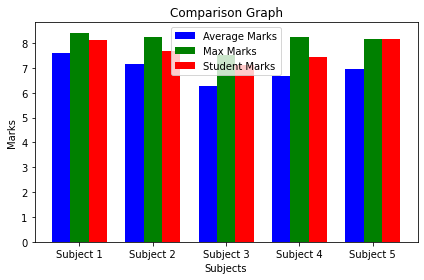

Start conversion to PDF
Succeeded.


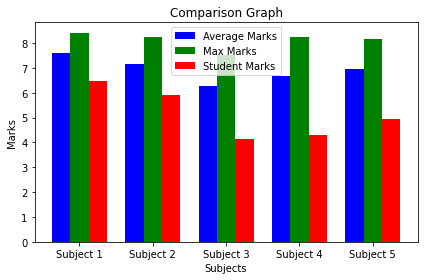

Start conversion to PDF
Succeeded.


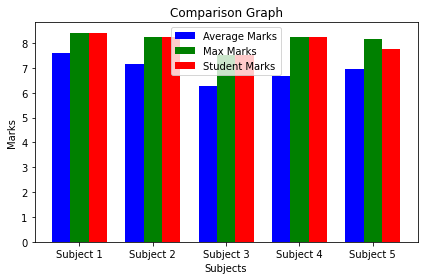

Start conversion to PDF
Succeeded.


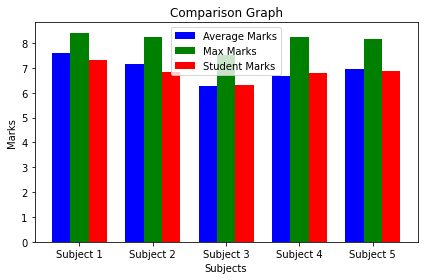

Start conversion to PDF
Succeeded.


In [8]:
def main():
    df = pd.read_excel("Required Format.xlsx")
    for i in range(len(df)):
        df = pd.read_excel("Required Format.xlsx")
        df, subject_names = format_dataframe(df)
        analysis, avg_marks, max_marks = gen_analysis(df)
        student = list(df.iloc[i])[5:10]
        graph = student_perf_graph(student, avg_marks, max_marks, subject_names)
        r = report_card(student, subject_names)
        r.to_excel("sample_file.xlsx", sheet_name = "Sheet_1", startrow = 4)
        x = list(df.iloc[i])
        y = x[-1]
        x = x[:5]
        x.append(y)
        final_format(r, x)
        convert_to_pdf(i)
main()